# TO BE REWORKED
(this is rafi's original jupyter notebook)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from typing import List, Dict, Any, Optional
from torchinfo import summary
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
from scipy.stats import pearsonr
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Model

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, pool_size: int, dropout: float):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = self.dropout(x)
        return x

In [3]:
class DREAMRNN(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        first_out_channels: int = 320,
        core_out_channels: int = 320,
        seqsize: int = 110,
        first_kernel_sizes: List[int] = [9, 15],
        core_kernel_sizes: List[int] = [9, 15],
        lstm_hidden_channels: int = 320,
        pool_size: int = 1,
        dropout_first: float = 0.2,
        dropout_core1: float = 0.2,
        dropout_core2: float = 0.5,
        hidden_dim_final: int = 64,
        num_tasks=12,
        target_length=2000
    ):
        super().__init__()

        each_first_out_channels = first_out_channels // len(first_kernel_sizes)
        self.first_conv_blocks = nn.ModuleList([
            ConvBlock(in_channels, each_first_out_channels, k, pool_size, dropout_first)
            for k in first_kernel_sizes
        ])

        each_core_out_channels = core_out_channels // len(core_kernel_sizes)
        self.lstm = nn.LSTM(
            input_size=first_out_channels,
            hidden_size=lstm_hidden_channels,
            batch_first=True,
            bidirectional=True
        )
        self.core_conv_blocks = nn.ModuleList([
            ConvBlock(2 * lstm_hidden_channels, each_core_out_channels, k, pool_size, dropout_core1)
            for k in core_kernel_sizes
        ])
        self.core_dropout = nn.Dropout(dropout_core2)

        self.final_mapper = nn.Conv1d(
            in_channels=core_out_channels,
            out_channels=256,
            kernel_size=1,
            padding='same'
        )
        self.final_linear = nn.Sequential(
            nn.Linear(256, 1)
        )

    def forward(self, x):
        first_conv_outputs = [conv(x) for conv in self.first_conv_blocks]
        x = torch.cat(first_conv_outputs, dim=1)

        x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)  # (batch_size, channels, seq_len)

        core_conv_outputs = [conv(x) for conv in self.core_conv_blocks]
        x = torch.cat(core_conv_outputs, dim=1)
        x = self.core_dropout(x)

        x = self.final_mapper(x)  # (batch_size, 256, seq_len)
        x = F.adaptive_avg_pool1d(x, 1)  # (batch_size, 256, 1)
        x = x.squeeze(2)  # (batch_size, 256)
        x = self.final_linear(x)  # (batch_size, 1)

        return x

In [4]:
batch_size = 1
seq_len = 230

model = DREAMRNN(seqsize=seq_len)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

integer_encoded_input = torch.randint(low=0, high=4, size=(batch_size, seq_len), dtype=torch.int64).to(device)
one_hot_encoded_input = torch.nn.functional.one_hot(integer_encoded_input, num_classes=4).float()
one_hot_encoded_input = one_hot_encoded_input.permute(0, 2, 1)

model.eval()
with torch.no_grad():
    output = model(one_hot_encoded_input)

print(f"Integer encoded input shape: {integer_encoded_input.shape}")
print(f"One-hot encoded input shape: {one_hot_encoded_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Predicted output:\n{output}")

Integer encoded input shape: torch.Size([1, 230])
One-hot encoded input shape: torch.Size([1, 4, 230])
Output shape: torch.Size([1, 1])
Predicted output:
tensor([[0.0533]], device='cuda:0')


In [5]:
model = DREAMRNN(seqsize=seq_len)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_shape = (batch_size, 4, seq_len)

summary(
    model,
    input_size=input_shape
)

Layer (type:depth-idx)                   Output Shape              Param #
DREAMRNN                                 [1, 1]                    --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 160, 230]             --
│    │    └─Conv1d: 3-1                  [1, 160, 230]             5,920
│    │    └─MaxPool1d: 3-2               [1, 160, 230]             --
│    │    └─Dropout: 3-3                 [1, 160, 230]             --
│    └─ConvBlock: 2-2                    [1, 160, 230]             --
│    │    └─Conv1d: 3-4                  [1, 160, 230]             9,760
│    │    └─MaxPool1d: 3-5               [1, 160, 230]             --
│    │    └─Dropout: 3-6                 [1, 160, 230]             --
├─LSTM: 1-2                              [1, 230, 640]             1,643,520
├─ModuleList: 1-3                        --                        --
│    └─ConvBlock: 2-3                    [1, 160, 230]             --
│ 

# dataLoader

In [6]:
CODES = {"A": 0, "T": 3, "G": 1, "C": 2, 'N': 4}
COMPL = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

def n2id(n: str) -> int:
    return CODES[n.upper()]

def revcomp(seq: str) -> str:
    return ''.join(COMPL[n.upper()] for n in reversed(seq))

In [7]:
class Seq2Tensor:
    def __call__(self, seq: str) -> torch.Tensor:
        indices = [n2id(base) for base in seq]
        arr = torch.tensor(indices, dtype=torch.long)
        one_hot = F.one_hot(arr, num_classes=5)[:, :4].float()  # Use only A, C, G, T
        return one_hot.T  # shape: (4, seq_len)

In [8]:
def preprocess_data(df: pd.DataFrame, seqsize: int) -> pd.DataFrame:
    df = df.copy()
    df['seq'] = df['seq']    #you can pad the seqeunce by adding adapters
    return df

def add_revcomp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rev = df.copy()
    rev['seq'] = df['seq'].apply(revcomp)
    rev['rev'] = 1
    df['rev'] = 0
    return pd.concat([df, rev], ignore_index=True)

def preprocess_tsv(path: str,seqsize: int) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ['seq', 'expr']
    df = preprocess_data(df, seqsize)
    df = add_revcomp(df)
    return df

In [9]:
class SeqExprDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, seqsize: int):
        self.df = df.reset_index(drop=True)
        self.encoder = Seq2Tensor()
        self.seqsize = seqsize

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        x = self.encoder(row['seq'])  # (4, seqsize)
        y = torch.tensor(row['expr'], dtype=torch.float32)  # scalar
        return {"x": x, "y": y}

In [10]:
class DataloaderWrapper:
    def __init__(self, dataloader: torch.utils.data.DataLoader, batch_per_epoch: int):
        self.dataloader = dataloader
        self.batch_per_epoch = batch_per_epoch
        self.iterator = iter(dataloader)

    def __iter__(self):
        for _ in range(self.batch_per_epoch):
            try:
                yield next(self.iterator)
            except StopIteration:
                self.iterator = iter(self.dataloader)

    def __len__(self):
        return self.batch_per_epoch

def prepare_dataloader(
    tsv_path: str,
    seqsize: int,
    batch_size: int = 32,
    num_workers: int = 0,
    shuffle: bool = True,
    generator: torch.Generator = None,
    batch_per_epoch: int = None
) -> torch.utils.data.DataLoader:
    
    df = preprocess_tsv(tsv_path, seqsize)
    dataset = SeqExprDataset(df, seqsize)
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        generator=generator
    )

    if batch_per_epoch is not None:
        return DataloaderWrapper(dataloader, batch_per_epoch)
    return dataloader

In [11]:
dataloader = prepare_dataloader(
    tsv_path="demo.txt",
    seqsize=230,
    batch_size=64,
    shuffle = True,
    num_workers = 8,
    batch_per_epoch=1000
)

for batch in dataloader:
    x, y = batch["x"], batch["y"]
    break

# Trainer

In [12]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        val_dataloader: Optional[torch.utils.data.DataLoader],
        model_dir: str | Path,
        num_epochs: int = 10,
        lr: float = 1e-3,
        weight_decay: float = 0.01,
        device: torch.device = torch.device("cpu")
    ):
        self.device = device
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.num_epochs = num_epochs

        div_factor = 25.0
        min_lr = lr / div_factor

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=min_lr,
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=lr,
            div_factor=div_factor,
            steps_per_epoch=len(train_dataloader),
            epochs=num_epochs,
            pct_start=0.3,
            three_phase=False
        )
        self.criterion = nn.MSELoss()
        self.best_pearson = -float("inf")

    def train_step(self, batch: dict[str, Any]) -> float:
        self.model.train()
        x = batch["x"].to(self.device)
        y = batch["y"].to(self.device).float()

        y_pred = self.model(x).squeeze()
        loss = self.criterion(y_pred, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.scheduler.step()

        return loss.item()

    def validate(self) -> dict[str, float]:
        self.model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in tqdm(self.val_dataloader, desc="Validation"):
                x = batch["x"].to(self.device)
                y = batch["y"].to(self.device).float()
                pred = self.model(x).squeeze()

                y_true.append(y.cpu().numpy())
                y_pred.append(pred.cpu().numpy())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        metrics = {
            "MSE": float(np.mean((y_pred - y_true) ** 2)),
            "pearsonr": float(np.corrcoef(y_true, y_pred)[0, 1])
        }
        return metrics

    def save_model(self, epoch: str):
        torch.save(self.model.state_dict(), self.model_dir / f"model_{epoch}.pth")
        torch.save(self.optimizer.state_dict(), self.model_dir / f"optimizer_{epoch}.pth")
        torch.save(self.scheduler.state_dict(), self.model_dir / f"scheduler_{epoch}.pth")

    def fit(self):
        for epoch in range(1, self.num_epochs + 1):
            epoch_losses = []
            for batch in tqdm(self.train_dataloader, desc=f"Epoch {epoch}"):
                loss = self.train_step(batch)
                epoch_losses.append(loss)

            with open(self.model_dir / "losses.json", "a") as f:
                json.dump({f"epoch_{epoch}": epoch_losses}, f)
                f.write("\n")

            if self.val_dataloader is not None:
                metrics = self.validate()
                with open(self.model_dir / "val_metrics.json", "a") as f:
                    json.dump({f"epoch_{epoch}": metrics}, f)
                    f.write("\n")
                print(metrics)

                if metrics["pearsonr"] > self.best_pearson:
                    self.best_pearson = metrics["pearsonr"]
                    self.save_model("best")
            # self.save_model(f"{epoch}")

# Read data and create train, validaiton, and test sets

### the below code expects your data to be in tab delimited format

In [13]:
df= pd.read_csv('WTC11_clean.tsv', sep ='\t')
df=df[['seq','mean_value']]

df.sample(5)

,seq,mean_value
25222,AGGACCGGATCAACTCTGAGTGCACAGTGCCCATGCATGCTTCCAA...,-1.364
42327,AGGACCGGATCAACTCTTTGAGTCTGTTGTTGGGATCCCGGTTCAC...,-0.094
28044,AGGACCGGATCAACTACTGAGCACCTTGTGACCCCCATCCCTGCCC...,-0.947
22565,AGGACCGGATCAACTTTTTTTTTTTTTTGAGACAGAGTTTCTCTCT...,-1.119
6436,AGGACCGGATCAACTCTTTTCTTCCTGGACCAAAGAATTTTCTCCG...,-0.132


In [14]:
df_trainval, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.1, random_state=42)
output_dir='data'
os.makedirs(output_dir, exist_ok=True)

df_train.to_csv(os.path.join(output_dir, "train.tsv"), sep="\t", index=False, header=False)
df_val.to_csv(os.path.join(output_dir, "val.tsv"), sep="\t", index=False, header=False)
df_test.to_csv(os.path.join(output_dir, "test.tsv"), sep="\t", index=False, header=False)

# Train model

In [16]:
train_path = "data/train.tsv"
val_path = "data/val.tsv"
model_dir = "checkpoints/bhi_run"

train_dl = prepare_dataloader(train_path, seqsize=230, num_workers=8, shuffle = True, batch_size=32, batch_per_epoch=1500)
val_dl = prepare_dataloader(val_path, seqsize=230, num_workers=8, shuffle=False, batch_size=32, batch_per_epoch=1500)

model = DREAMRNN()

trainer = Trainer(
    model=model,
    train_dataloader=train_dl,
    val_dataloader=val_dl,
    model_dir=model_dir,
    num_epochs=20,
    lr=0.005,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

trainer.fit()

Validation: 100%|█████████████████████████▉| 1496/1500 [00:13<00:00, 109.29it/s]


{'MSE': 1.0643181800842285, 'pearsonr': 0.35865242447027046, 'spearmanr': -0.003180297165449158}


Validation: 100%|█████████████████████████▉| 1495/1500 [00:14<00:00, 100.82it/s]


{'MSE': 0.9373032450675964, 'pearsonr': 0.4808911731087611, 'spearmanr': -0.00739404196041969}


Validation: 100%|█████████████████████████▉| 1495/1500 [00:14<00:00, 102.26it/s]


{'MSE': 0.9472252130508423, 'pearsonr': 0.5128510985791942, 'spearmanr': -0.002448048536456901}


Validation: 100%|█████████████████████████▉| 1496/1500 [00:13<00:00, 109.64it/s]


{'MSE': 0.8679746985435486, 'pearsonr': 0.5416207465255969, 'spearmanr': 0.004277713626881826}


Validation: 100%|█████████████████████████▉| 1495/1500 [00:14<00:00, 106.54it/s]


{'MSE': 0.8021082282066345, 'pearsonr': 0.565346185207851, 'spearmanr': 0.00197677196922856}


Epoch 6:  30%|█████████▎                     | 450/1500 [00:09<00:22, 46.32it/s]

KeyboardInterrupt



# Evaluate model on Test set

In [24]:
model_weights_path = "checkpoints/bhi_run/model_best.pth"
test_data_path = "data/test.tsv"
seqsize = 230
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_test = preprocess_tsv(test_data_path, seqsize=seqsize)
test_ds = SeqExprDataset(df_test, seqsize=seqsize)
test_dl = torch.utils.data.DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False
    )

model = DREAMRNN()
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.to(device)
model.eval()

DREAMRNN(
  (first_conv_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Conv1d(4, 160, kernel_size=(9,), stride=(1,), padding=same)
      (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv1d(4, 160, kernel_size=(15,), stride=(1,), padding=same)
      (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (lstm): LSTM(320, 320, batch_first=True, bidirectional=True)
  (core_conv_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Conv1d(640, 160, kernel_size=(9,), stride=(1,), padding=same)
      (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv1d(640, 160, kernel_size=(15,), stride=(1,), padding=same)
      (pool): MaxPool1d(kernel_size=1, stride=

### keeping forward and reverse strands separate

In [34]:
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in tqdm(test_dl):
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        y_pred = model(x).squeeze()
        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)
pearson_r = pearsonr(y_true, y_pred)[0]
print(f"Pearson correlation (r) on test set: {pearson_r:.4f}")

100%|█████████████████████████████████████████| 175/175 [00:03<00:00, 57.26it/s]

Pearson correlation (r) on test set: 0.5612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


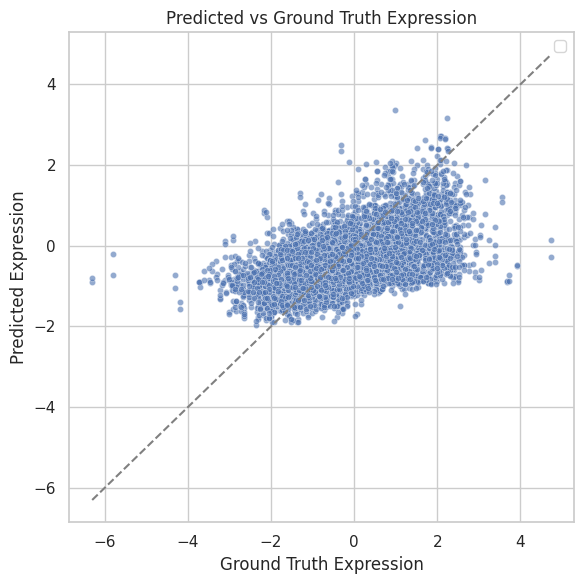

In [37]:
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")

sns.scatterplot(x=y_true, y=y_pred, s=20, alpha=0.6)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

plt.xlabel("Ground Truth Expression")
plt.ylabel("Predicted Expression")
plt.title("Predicted vs Ground Truth Expression")
plt.legend()
plt.tight_layout()
plt.show()

### averaging forward and reverse strands

In [38]:
pred_dict = defaultdict(list)
true_dict = {}

with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
        x = batch["x"].to(device)
        y = batch["y"].to(device).cpu().numpy()
        preds = model(x).squeeze().cpu().numpy()
        
        batch_df = df_test.iloc[i * batch_size: i * batch_size + len(preds)]

        for j, row in batch_df.iterrows():
            seq_key = row['seq'] if row['rev'] == 0 else revcomp(row['seq'])
            pred_dict[seq_key].append(preds[j % len(preds)])
            true_dict[seq_key] = y[j % len(preds)]
            
y_true = []
y_pred = []

for seq_key in pred_dict:
    y_pred.append(np.mean(pred_dict[seq_key]))
    y_true.append(true_dict[seq_key])

y_pred = np.array(y_pred)
y_true = np.array(y_true)

pearson_r = pearsonr(y_true, y_pred)[0]
print(f"Pearson correlation (r) with forward+reverse averaging: {pearson_r:.4f}")

175it [00:03, 44.44it/s]

Pearson correlation (r) with forward+reverse averaging: 0.5811


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


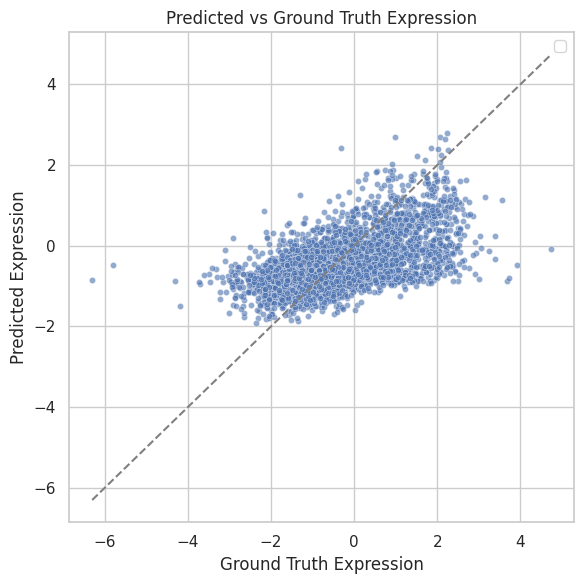

In [39]:
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")

sns.scatterplot(x=y_true, y=y_pred, s=20, alpha=0.6)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

plt.xlabel("Ground Truth Expression")
plt.ylabel("Predicted Expression")
plt.title("Predicted vs Ground Truth Expression")
plt.legend()
plt.tight_layout()
plt.show()

# Design seqeunces with TF motif and analyze model predictions

In [45]:
def insert_motif(seq, motif, pos):
    return seq[:pos] + motif + seq[pos + len(motif):]

def generate_random_seq(seqsize):
    return ''.join(random.choices(['A', 'C', 'G', 'T'], k=seqsize))

def encode_batch(seq_list):
    with torch.no_grad():
        encoded = [encoder(s).unsqueeze(0) for s in seq_list]
        return torch.cat(encoded, dim=0).to(device)

In [49]:
seqsize = 230
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

background = "AGGACCGGATCAACTCTCTCTACTCAGATGGGTCCTCAGACCCCTAACACAGCGTTCAGGCAGGCATTCATAATCGGTTTAGCATTGGCACTCGTGACAATGCCTATTTACTATTCTTGACAGAAGAATGCAGCCCATGGCCTGCCTGACCCTATCAGTTGAATAACAAAAGGAGAACAATTACTCCCTCGTCTGTCACCTTTCTGAATCCATCCCATTGCGTGAACCGA"
motif1 = "CACGTG"
motif2 = "TGCATG"

encoder = Seq2Tensor()

num_seqs=100
motif_start_pos=15 # no motif will be put before this 
motif_end_pos = 15 # no motif will be put after this

random_seqs = [generate_random_seq(seqsize) for _ in range(num_seqs)]
motif1_seqs = [insert_motif(background[:seqsize], motif1, random.randint(motif_start_pos, seqsize - len(motif1) - motif_end_pos)) for _ in range(num_seqs)]
motif2_seqs = [insert_motif(background[:seqsize], motif2, random.randint(motif_start_pos, seqsize - len(motif2) - motif_end_pos)) for _ in range(num_seqs)]

In [51]:
X_random = encode_batch(random_seqs)
X_motif1 = encode_batch(motif1_seqs)
X_motif2 = encode_batch(motif2_seqs)

model = DREAMRNN()
model.load_state_dict(torch.load("checkpoints/bhi_run/model_best.pth", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    y_random = model(X_random).squeeze().cpu().numpy()
    y_motif1 = model(X_motif1).squeeze().cpu().numpy()
    y_motif2 = model(X_motif2).squeeze().cpu().numpy()

/home/muntakimrafi/anaconda3/envs/dream/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/muntakimrafi/anaconda3/envs/dream/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/muntakimrafi/anaconda3/envs/dream/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/muntakimrafi/anaconda3/envs/dream/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


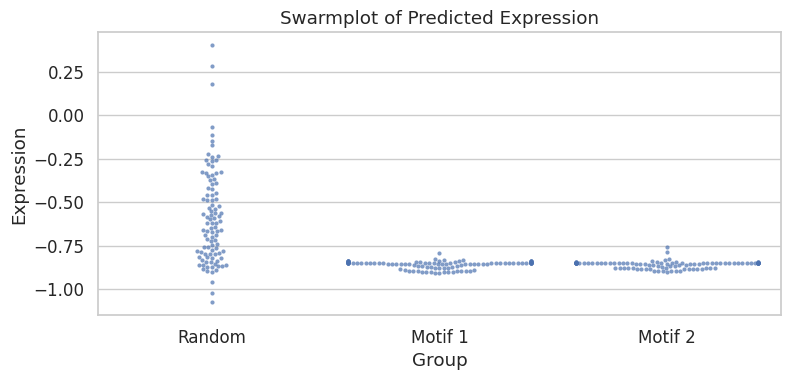

In [54]:
df_plot = pd.DataFrame({
    "Expression": np.concatenate([y_random, y_motif1, y_motif2]),
    "Group": (["Random"] * len(y_random) +
              ["Motif 1"] * len(y_motif1) +
              ["Motif 2"] * len(y_motif2))
})

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(8, 4))
sns.swarmplot(x="Group", y="Expression", data=df_plot, size=3, alpha=0.7)
plt.title("Swarmplot of Predicted Expression")
plt.tight_layout()
plt.show()

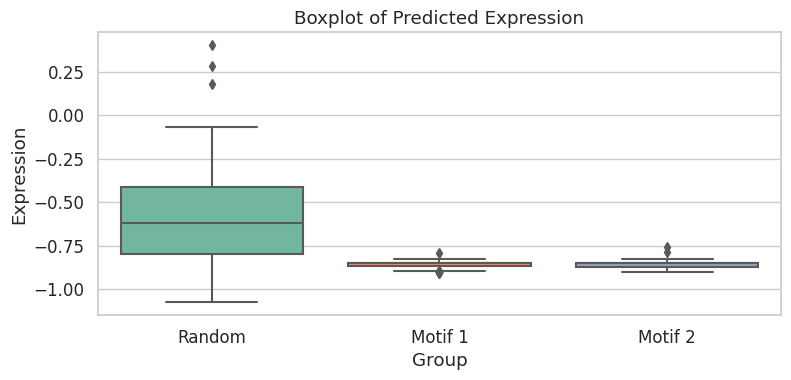

In [56]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="Group", y="Expression", data=df_plot, palette="Set2")
plt.title("Boxplot of Predicted Expression")
plt.tight_layout()
plt.show()